## Introduction

The dataset investigated here is the 'Subnational Indicators Dataset' from the Office of National Statistics and can be retrieved from [here](https://www.ons.gov.uk/peoplepopulationandcommunity/wellbeing/datasets/subnationalindicatorsdataset). 

The dataset gives information on indicators such as weekly income, gross value added, health, wellness and education, as well as many others, all broken down by Local Authority District/Unitary Authority (all hereafter referred to as districts). I am interested in general questions regarding how the weekly income of a given district relates to other indicators. For example, do areas designated as 'low income' see a lower healthy life expectancy and generally worse health than areas with high income? Are people less anxious in higher income areas? Are high-income areas generally more productive? Does the level of education in a district correlate with health indicators, and what does this tell us in relation to the district income bracket? 

### Initial examination of the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from empiricaldist import Cdf, Pmf
from scipy import stats
from functions import *
import joblib

sns.set_palette("Set2")

In [2]:
df = joblib.load('full_df.jlib')

In [3]:
df.head()

,area_code,area,anxiety,car_avg_travel,broadband,worthwhile,cycle_avg_travel,male_hle,male_hle_lower_ci,male_hle_upper_ci,...,early_yrs_lit,smoking,smoking_lower_ci,smoking_upper_ci,life_satisfaction,apprenticeships_completions,early_yrs_comms,apprenticeships_starts,early_yrs_maths,happiness
0,E06000001,Hartlepool,3.39,7.8,5.3,7.68,10.1,57.0,55.3,58.8,...,73.5,15.9,12.4,19.4,7.33,370.0,79.3,660.0,76.9,7.21
1,E06000002,Middlesbrough,3.11,8.5,5.6,7.62,11.3,58.5,56.8,60.2,...,63.9,12.8,9.2,16.3,7.21,470.0,71.8,900.0,68.2,7.26
2,E06000003,Redcar and Cleveland,3.16,8.1,1.5,7.76,11.1,60.2,58.4,62.1,...,72.2,13.4,10.6,16.3,7.44,560.0,79.9,980.0,77.6,7.49
3,E06000004,Stockton-on-Tees,3.25,7.8,5.7,7.74,10.1,57.8,55.8,59.7,...,74.6,10.8,7.8,13.8,7.40,740.0,84.4,1400.0,79.9,7.25
4,E06000005,Darlington,3.63,7.5,2.9,7.55,9.5,58.1,56.2,60.0,...,73.2,13.5,10.0,16.9,7.25,390.0,78.1,730.0,77.1,7.12


In [4]:
#Check shape
df.shape

(382, 41)

In [5]:
len([col for col in df.columns[2:] if '_ci' not in col])

25

We have 382 Local Authority Districts and Unitary Authorities and 27 subnational indicators (once we have filtered out those indicating confidence intervals and area codes/names), so this is a relatively small dataset.

In [6]:
#Check dtypes
df.dtypes

area_code                             object
area                                  object
anxiety                              float64
car_avg_travel                       float64
broadband                            float64
worthwhile                           float64
cycle_avg_travel                     float64
male_hle                             float64
male_hle_lower_ci                    float64
male_hle_upper_ci                    float64
schools_nurseries                    float64
employment_rate                      float64
public_transport_avg_travel          float64
increase_dwellings                   float64
gcses                                float64
female_hle                           float64
female_hle_lower_ci                  float64
female_hle_upper_ci                  float64
income                               float64
gva_ph                               float64
4g                                   float64
overweight_adults                    float64
overweight

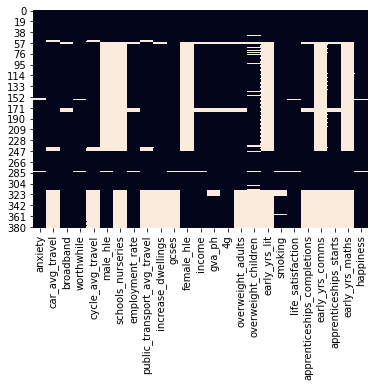

In [7]:
#Check for nulls
sns.heatmap(df[[col for col in df.columns[2:] if '_ci' not in col]].isnull(), 
            cbar=False);

We'll first take a look at the distribution of incomes over the districts and then bin these into high-, mid- and low-income areas.

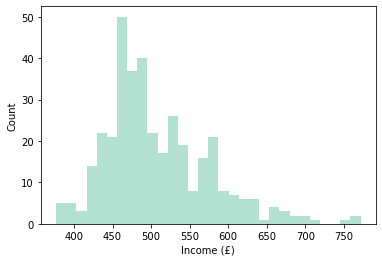

In [8]:
income = df['income']

plt.hist(income, bins=30, alpha=0.5)
plt.ylabel('Count')
plt.xlabel('Income (£)');

In [9]:
df[['income']].describe().T

,count,mean,std,min,25%,50%,75%,max
income,369.0,507.760434,67.923124,376.8,460.3,490.3,545.8,771.6


- Right-skewed distribution, i.e. towards larger weekly incomes.

Create labels for high-, mid- and low-income districts. As we expect outliers in the data, we use the median absolute deviation (MAD) to categorise each of the district incomes using the scipy stats module.

In [10]:
MAD = stats.median_abs_deviation(income, nan_policy='omit')
MAD

37.99999999999994

Note that the standard deviation is much greater than the MAD, indicating, as expected from the histogram, the presence of outliers.

In [11]:
np.std(income)

67.83102475707692

So, criteria for high-, mid- and low-income districts are as follows:
- if income > median + MAD, then 'high';
- if income < median - MAD, then 'low';
- otherwise, 'mid'.

In [12]:
income_med = income.median()

df['income_bracket'] = income.apply(lambda x: 'high' if x > income_med + MAD 
                                    else 'low' if x <= income_med - MAD
                                   else 'mid')

In [13]:
df['income_bracket'].value_counts(normalize=True)

mid     0.523560
high    0.308901
low     0.167539
Name: income_bracket, dtype: float64

Let's compare this result to if we had used the mean/standard deviation.

In [14]:
income_std = income.std()
income_mean = income.mean()

df['income_bracket_std'] = income.apply(lambda x: 'high' if x > income_mean + income_std 
                                    else 'low' if x <= income_mean - income_std
                                   else 'mid')

In [15]:
df['income_bracket_std'].value_counts(normalize=True)

mid     0.738220
high    0.146597
low     0.115183
Name: income_bracket_std, dtype: float64

If income were normally distributed, we'd expect to see about the same fraction of the population in high and low and about 68% in mid when we split according to the mean and standard deviation, but we see more in the mid and high categories.

In contrast, when we split according to MAD, we see a smaller proportion in the mid category, more in low, and a much larger proportion in high, which reflects the right-skewed nature of the distribution.

The vertical lines in the plot below indicate the thresholds from low-to-mid and mid-to-high income boundaries. 

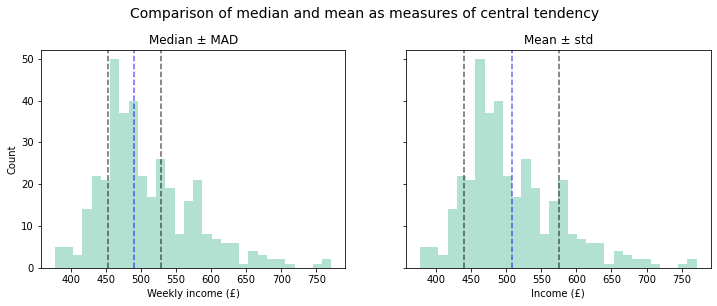

In [141]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))

ax[0].hist(income, bins=30, alpha=0.5)
ax[0].plot([income_med - MAD, income_med - MAD], [0, 52], color='k', linestyle='--', alpha=0.6)
ax[0].plot([income_med, income_med], [0,52], color='blue', linestyle='--', alpha=0.6)
ax[0].plot([income_med + MAD, income_med + MAD], [0, 52], color='k', linestyle='--', alpha=0.6)
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Weekly income (£)')
ax[0].set_title('Median ± MAD')

ax[1].hist(income, bins=30, alpha=0.5)
ax[1].plot([income_mean - income_std, income_mean - income_std], [0, 52], color='k', linestyle='--', alpha=0.6)
ax[1].plot([income_mean, income_mean], [0,52], color='blue', linestyle='--', alpha=0.6)
ax[1].plot([income_mean + income_std, income_mean + income_std], [0, 52], color='k', linestyle='--', alpha=0.6)
ax[1].set_xlabel('Income (£)')
ax[1].set_title('Mean ± std')

plt.suptitle('Comparison of median and mean as measures of central tendency', fontsize=14, y=1.03)
plt.ylim((0,52));

In [17]:
print(income_med - MAD, income_mean - income_std, income_med - MAD - (income_mean - income_std))
print(income_med + MAD, income_mean + income_std, income_med + MAD - (income_mean + income_std))

452.30000000000007 439.83730965377873 12.462690346221336
528.3 575.6835575548935 -47.383557554893514


We'll broadly split our data into categories of health, education, wellness and other, and investigate them in turn.

In [18]:
health = ['male_hle', 'female_hle', 'smoking', 'overweight_adults', 'overweight_children']

education = ['schools_nurseries', 'gcses', 'early_yrs_lit', 'early_yrs_comms', 'early_yrs_maths', 
            'apprenticeships_starts', 'apprenticeships_completions']

wellness = ['anxiety', 'worthwhile', 'life_satisfaction', 'happiness']

other = ['gva_ph', 'car_avg_travel', 'cycle_avg_travel', 'public_transport_avg_travel', 'broadband', '4g']

We would like to investigate these features when broken down by income bracket, and a quick way of doing so is to plot the distributions as swarmplots alongside the empirical cumulative distribution functions (ECDFs). The following function will do so for multiple features at once. 

In [19]:
#Boolean masks for plotting income brackets
high = (df['income_bracket'] == 'high')
mid = (df['income_bracket'] == 'mid')
low = (df['income_bracket'] == 'low')

#Lists for plotting
masks = [low, mid, high]
labels = ['Low', 'Mid', 'High']

def compare_dists(data, features, titles, masks=masks, labels=labels):
    nrows = len(features)
    if nrows == 1:
        fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

        sns.swarmplot(x='income_bracket', y=features[0], data=data, size=4.1,
                          order=[l.lower() for l in labels], ax=ax[0])
        dummy = data[features[0]]
        for mask, label in zip(masks, labels):
            x, y = ecdf(dummy[mask].dropna())
            sns.scatterplot(x=x, y=y, s=20, label=label, ax=ax[1])

        ax[0].set_xlabel('Income bracket')
        ax[0].set_ylabel(titles[0])
        ax[1].set_ylabel('ECDF')
        ax[1].set_xlabel(titles[0])

        plt.show()

    else:
        fig, ax = plt.subplots(figsize=(12, 4*nrows), ncols=2, nrows=nrows)

        #Plot swarm and ECDF
        for i, (feature, title) in enumerate(zip(features, titles)):
            sns.swarmplot(x='income_bracket', y=feature, data=data, size=4.1,
                          order=[l.lower() for l in labels], ax=ax[i][0])

            dummy = data[feature]
            for mask, label in zip(masks, labels):
                x, y = ecdf(dummy[mask].dropna())
                sns.scatterplot(x=x, y=y, s=20, label=label, ax=ax[i][1])

            ax[i][0].set_xlabel('Income bracket')
            ax[i][0].set_ylabel(title)
            ax[i][1].set_ylabel('ECDF')
            ax[i][1].set_xlabel(title)

        plt.show()


### Health

We first examine the male and female HLE distributions.

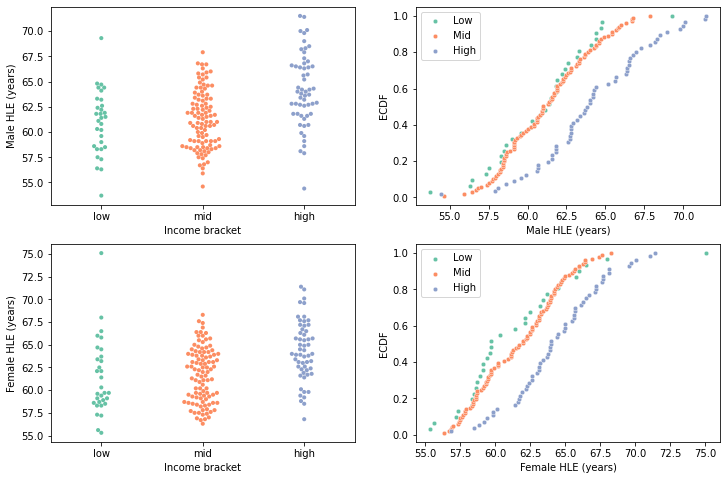

In [20]:
features = ['male_hle', 'female_hle']
titles = ['Male HLE (years)', 'Female HLE (years)']

compare_dists(df, features, titles)

Examining the swarmplots on the left, we can see that there is a general trend that people who live in high-income districts tend to enjoy a longer healthy life-expectancy (HLE) than those in mid- or low-income districts. The ECDFs on the right make this more explicit, where it is clear that for both males and females the proportion of the populations enjoying a relative increase in HLE is higher for high-income districts. For the male HLE mid- and low-income districts the ECDFs are similar, and the median male HLE is about 2.5 years longer than for low- and mid-income districts. For females there is a noticeable stall in HLE below 60 years; indeed, 50% of the population have an HLE less than 60 years compared to 62 and 64 years for mid- and high-income districts, respectively, so we see a four-year increase in median HLE from low- to high-income districts.

In [21]:
df[['male_hle', 'female_hle', 'income_bracket']].groupby('income_bracket') \
.describe().iloc[:, [4, 5, 6, 12, 13, 14]].loc[['low', 'mid', 'high']]

male_hle               female_hle             
                    25%   50%     75%        25%   50%    75%
income_bracket                                               
low               58.55  61.4  62.900     58.650  59.7  63.55
mid               58.90  61.0  63.300     59.100  62.0  64.00
high              61.80  63.9  66.525     62.275  64.0  66.55

That said, there is one interesting point that has the longest female HLE (~75 years) but is in a low-income area: the Orkney Islands.

In [22]:
df[df['female_hle'] > 75][['area', 'female_hle', 'income_bracket']]

,area,female_hle,income_bracket
340,Orkney Islands,75.1,low


On the other end of the scale, there are three districts, one in each income bracket, that have a male HLE of shorter than 55 years: Blackpool, Belfast and Glasgow City. 

In [23]:
df[df['male_hle'] < 55][['area', 'male_hle', 'income_bracket']]

,area,male_hle,income_bracket
8,Blackpool,53.7,low
319,Belfast,54.4,high
358,Glasgow City,54.6,mid


The following are plots of the percentage of adults smoking in each of the districts.

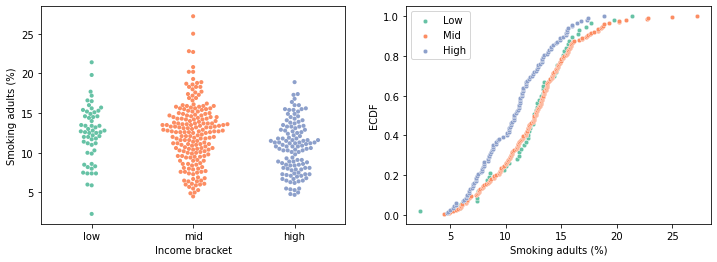

In [24]:
features = ['smoking']
titles = ['Smoking adults (%)']

compare_dists(df, features, titles)

Here we see that high-income districts tend to have a smaller proportion of the population that smoke, as is made clear by the ECDF, where the high-income curve sits to the left (smaller percentages) of the mid- and low-income curves, which track similarly. There is an approximate 2% decrease in median for high-income districts compared to the other income brackets.

In [25]:
df[['smoking', 'income_bracket']].groupby('income_bracket') \
.describe().iloc[:, [4, 5, 6]].loc[['low', 'mid', 'high']]

smoking            
                   25%   50%   75%
income_bracket                    
low               10.3  12.6  14.6
mid               10.0  12.7  14.7
high               8.1  10.8  12.9

It is notable that in one low-income district, Ryedale, the percentage of smoking adults is as low as 2.3% while the largest proportion lies in the mid-income district Corby, in which around 27% of adults are currently smoking. 

In [26]:
df[df['smoking'] < 3][['area', 'smoking', 'income_bracket']]

,area,smoking,income_bracket
183,Ryedale,2.3,low


In [27]:
df[['area', 'smoking', 'income_bracket']].sort_values(by='smoking', ascending=False).head(1)

,area,smoking,income_bracket
172,Corby,27.2,mid


The following plot the percentages of adult and child populations that are overweight or obese.

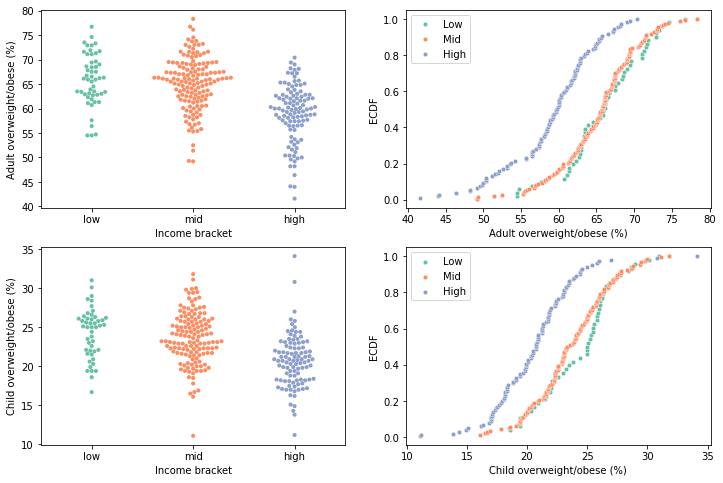

In [28]:
features = ['overweight_adults', 'overweight_children']
titles = ['Adult overweight/obese (%)', 'Child overweight/obese (%)']

compare_dists(df, features, titles)

We note that, particularly for adults, these numbers are concerning: in every income bracket, half of the districts have over 60% of the population classified as overweight or obese, and in several low- and mid-income districts this rises to over 75%. In the case of children, we see that half of districts have between a fifth and a quarter of the population classified as overweight or obese, and in several districts this is over 30%. In addition, we see the trend observed with the other health indicators repeated here: while the low- and mid-income districts tend to track similarly, high-income districts enjoy generally a lower proportion of adults and children that are classified as overweight or obese. The median for high-income district adults is about 6% lower than for low-/mid-income ones, and for children we see a decrease from about 25% to 23% to 21% from low- to mid- to high-income districts. 

In [29]:
df[['overweight_adults', 'overweight_children', 'income_bracket']].groupby('income_bracket') \
.describe().iloc[:, [4, 5, 6, 12, 13, 14]].loc[['low', 'mid', 'high']]

overweight_adults                overweight_children         \
                             25%    50%     75%                 25%    50%   
income_bracket                                                               
low                        62.85  66.10  69.500              21.975  25.05   
mid                        62.15  65.85  68.675              21.700  23.45   
high                       56.50  59.80  62.700              18.300  20.70   

                        
                   75%  
income_bracket          
low             26.125  
mid             25.800  
high            22.400

In [30]:
df[df['overweight_adults'] > 75][['area', 'overweight_adults', 'income_bracket']]

,area,overweight_adults,income_bracket
5,Halton,78.3,mid
20,Stoke-on-Trent,76.1,mid
72,Bolsover,76.7,low
274,Sandwell,76.7,mid


### Education

Plot education indicators grouped by income bracket.

The `schools_nurseries` feature gives the percentage of schools in a district that were rated good or outstanding by OFSTED.

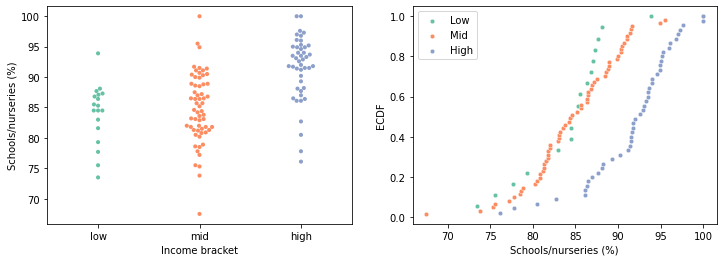

In [31]:
features = ['schools_nurseries']
titles = ['Schools/nurseries (%)']

compare_dists(df, features, titles)

There are much fewer data points — 124 out of a possible 382 — than we see in the health indicators, which is interesting, since I would have thought this information would be available from OFSTED for all schools in a given district. That said, with the reduced sample size (which contains a similar normalised class distribution, though we see about a 5% increase in high-income districts that reported this information and a 2–3% decrease in mid- and low-income districts) we still see the same pattern of a higher proportion of high-income schools and nurseries being of a higher quality. That is, in general, children in high-income districts have access to better education, as we can see from the clear separation of the high-income ECDF from the other income brackets. In particular, only 25% of high-income districts have less than 88% good/outstanding schools, whereas 50% of low- and mid-income districts have less than around 85% good/outstanding. We also note that half of high-income districts have more than 92% of schools/nurseries rated as good/outstanding, so the provision of education in high-income districts is generally excellent. In addition, there is one mid-income district that has a particularly low proportion of good schools and nurseries: Doncaster.

In [32]:
df['schools_nurseries'].notna().value_counts()

False    258
True     124
Name: schools_nurseries, dtype: int64

In [33]:
df[df['schools_nurseries'].notna()]['income_bracket'].value_counts(normalize=True)

mid     0.491935
high    0.362903
low     0.145161
Name: income_bracket, dtype: float64

In [34]:
df['income_bracket'].value_counts(normalize=True)

mid     0.523560
high    0.308901
low     0.167539
Name: income_bracket, dtype: float64

In [35]:
df[['schools_nurseries', 'income_bracket']].groupby('income_bracket') \
.describe().iloc[:, [4, 5, 6]].loc[['low', 'mid', 'high']]

schools_nurseries              
                             25%   50%     75%
income_bracket                                
low                        81.95  84.9  87.025
mid                        81.30  84.6  88.900
high                       88.20  92.6  94.900

In [36]:
df[df['schools_nurseries'] < 70][['area', 'schools_nurseries', 'income_bracket']]

,area,schools_nurseries,income_bracket
264,Doncaster,67.5,mid


The `gcses` feature gives the percentage of young people achieving GCSEs or equivalent in Maths and English, and the `early_yrs` features give the percentage of five-year-olds achieving 'expected level' in literacy, communication and maths.

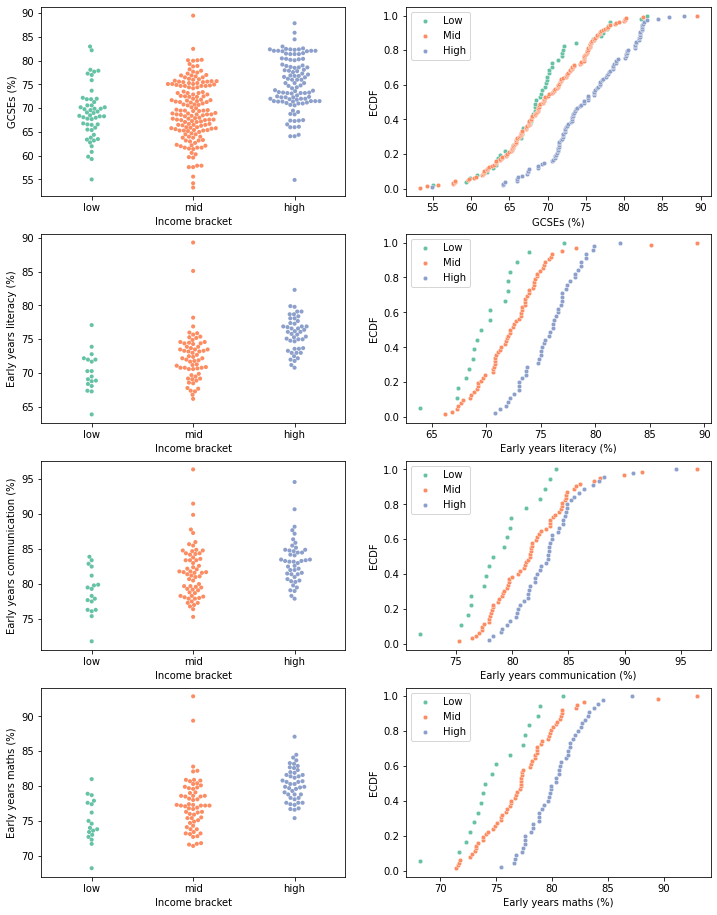

In [37]:
features = ['gcses', 'early_yrs_lit', 'early_yrs_comms', 'early_yrs_maths']
titles = ['GCSEs (%)', 'Early years literacy (%)', 'Early years communication (%)', 'Early years maths (%)']

compare_dists(df, features, titles)

Regarding GCSEs, we see the now familiar trend that high-income districts tend to have a relatively high percentage of students achieving Maths and English GCSEs, and this decreases from mid- to low-income districts. The difference between income brackets is even more noticeable in Early Years education, where there is a clear separation and an increase in the proportion of children achieving expected level from low- to mid- to high-income districts. In terms of the median, this manifests as an ~6% decrease from high- to low-income districts.

In [38]:
df[['gcses', 'early_yrs_lit', 'early_yrs_comms', 'early_yrs_maths', 'income_bracket']].groupby('income_bracket') \
.describe().iloc[:, [4, 5, 6, 12, 13, 14, 20, 21, 22, 28, 29, 30]].loc[['low', 'mid', 'high']]

gcses               early_yrs_lit                \
                   25%    50%    75%           25%   50%     75%   
income_bracket                                                     
low             65.700  68.50  71.60          68.5  69.9  72.000   
mid             65.625  69.45  74.70          70.6  72.3  74.375   
high            71.500  74.80  79.65          73.6  76.1  77.400   

               early_yrs_comms               early_yrs_maths                
                           25%   50%     75%             25%   50%     75%  
income_bracket                                                              
low                     76.600  78.8  80.875           73.10  74.3  77.550  
mid                     78.875  81.6  84.100           74.95  77.2  79.475  
high                    81.400  83.2  84.800           78.30  80.3  81.900

There are several districts that have less than 55% of young people obtaining Maths and English GCSEs; interestingly, these are all mid- or high-income districts.

In [41]:
df[df['gcses'] < 55][['area', 'gcses', 'income_bracket']]

,area,gcses,income_bracket
88,Hastings,53.3,mid
133,Sevenoaks,54.9,high
201,Cannock Chase,54.2,mid


It's clear from what we've seen so far that, generally speaking, an increase in weekly income is associated with improved educational (more schools and nurseries rated good/outstanding, more children achieving Maths and English GCSEs, and improved Early Years literacy, communication and maths) and health (a lower proportion of the adult population that smokes, improved HLE for males and females, and a lower proportion of the adult and child populations that are classified as overweight or obese) outcomes for a given district. That said, there is significant overlap between the populations such that we see, for example, some high-income districts with some relatively poor health/education outcomes and, conversely, some low-income districts with relatively good health/education outcomes.

It would now be interesting to see whether these factors are correlated.

## Investigating relationships between health, education and income

We have various health and education indicators, and it would be useful to combine these into a single metric so that we can see if, for example, low income for a district implies poor outcomes in both education and health (or the converse). We're limited in this because (1) there are largely different numbers of districts that reported each feature (e.g. 188 out of 382 districts reported on HLE but 367 reported the percentage of adult smokers) and (2) the metrics are on different scales (e.g. HLE is reported in years and greater implies positive, whereas smoking is reported as a percentage and smaller implies positive). I'm not sure of a robust way to deal with these points (i.e. combine the features into a pair of educational and health indexes), so instead we'll take the following approach.
- Investigate correlations between the features and see if some might be a better general representation of health/education than others. For example, for a given district, if we see that a large proportion of the population smokes and is overweight, we might expect to see this reflected in a lower HLE, and we could therefore use the latter as a general health indicator. 
- Once we have a reduced feature set, we can plot health versus education and color the districts by income bracket. From what we've seen so far, we might expect that low(high)-income districts might more often appear with relatively poor (good) health and education features.

### HLE, smoking and instances of obesity

Below are scatterplots of male and female HLE against the smoking and overweight/obese indicators, along with the Pearson correlation coefficient, $\rho$, which indicates the strength and direction of the relationship between the variables.

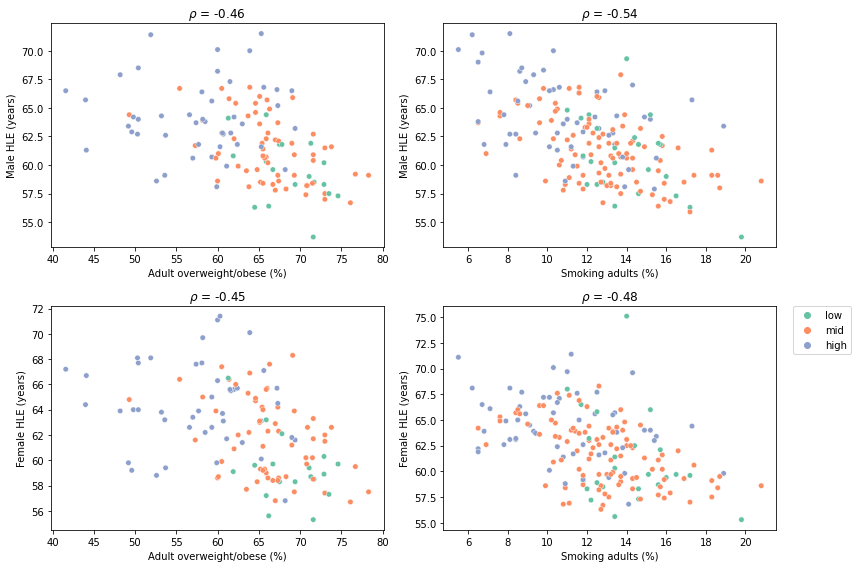

In [96]:
#Scatter plot of HLE vs smoking/obesity with Pearson corr coeff
fig, ax = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)

hles = ['male_hle', 'female_hle']
indicators = ['overweight_adults', 'smoking']
title_hle = ['Male HLE (years)', 'Female HLE (years)']
title_indicators = ['Adult overweight/obese (%)', 'Smoking adults (%)']

for i, hle in enumerate(hles):
    for j, indicator in enumerate(indicators):
        mask = (df[hle].notna() & df[indicator].notna())    
        dummy = df[mask]
        sns.scatterplot(x=indicator, y=hle, data=dummy, hue='income_bracket', 
                        s=30, hue_order=['low', 'mid', 'high'], ax=ax[i][j])
        rho = round(np.corrcoef(dummy[indicator].dropna(), dummy[hle].dropna())[0,1], 2)
        ax[i][j].set_title(f'$\\rho$ = {rho}')
        ax[i][j].legend([],[], frameon=False)
        ax[i][j].set_xlabel(title_indicators[j])
        ax[i][j].set_ylabel(title_hle[i])
        
ax[len(hles)-1][len(hles)-1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

For all relationships, we can see that $\rho$ is negative, indicating that for both males and females an increase in the proportion of overweight and smoking adults is accompanied by a decrease in average HLE in the district. The districts have also been coloured according to income bracket and, as expected from the previous plots, there is large overlap between the populations, though the high-income districts do tend to inhabit the top-left quadrant, where HLE is relatively high and the incidence of obesity and smoking is relatively low.

### Pass rates and access to good or outstanding schools

Turning to education, we would expect that the availability of good schools and nurseries would be related to the proportion of children attaining core GCSEs and attaining the expected level in Early Years education. For simplicity, we combine the Early Years scores into a single metric by taking a simple arithmetic mean and plot this and GCSEs against the schools/nurseries feature. 

In [108]:
df['early_yrs'] = ((df['early_yrs_comms'] + df['early_yrs_lit'] + df['early_yrs_maths'])/3).round(2)

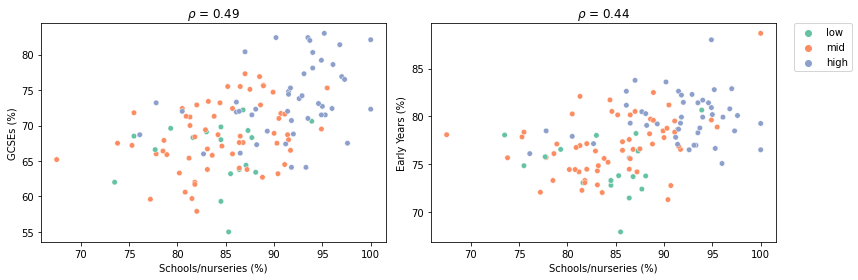

In [113]:
#Scatter plot of proportion of good schools vs educational outcomes with Pearson corr coeff
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)

indicators = ['gcses', 'early_yrs']
title_indicators = ['GCSEs (%)', 'Early Years (%)']

for i, indicator in enumerate(indicators):
    mask = (df['schools_nurseries'].notna() & df[indicator].notna())    
    dummy = df[mask]
    sns.scatterplot(x='schools_nurseries', y=indicator, data=dummy, hue='income_bracket', 
                    s=30, hue_order=['low', 'mid', 'high'], ax=ax[i])
    rho = round(np.corrcoef(dummy[indicator].dropna(), dummy['schools_nurseries'].dropna())[0,1], 2)
    ax[i].set_title(f'$\\rho$ = {rho}')
    ax[i].legend([],[], frameon=False)
    ax[i].set_ylabel(title_indicators[i])
    ax[i].set_xlabel('Schools/nurseries (%)')
        
ax[len(hles)-1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

We see from the plots and coefficients that, as expected, there is a positive correlation between the availability of good/outstanding schools and the proportion of school children that are achieving well in schools. We further note that high-income districts largely appear in the top-right of these plots, where there are a high percentage of good schools and correspondingly large proportions of children attaining the expected level at GCSE and in Early Years education. 

It seems from the (admittedly simplistic) analysis above that since the proportion of good schools and nurseries reflects, to some extent, the level of education, and since the HLE similarly appears to reflect the levels of the other health indicators, we could take these two as rough indicators of the respective levels of education and health within in a given district. In order to do so, we take an arithmetic mean of the male and female HLEs and plot these against schools/nurseries, coloured by income bracket. The plot is also annotated with the respective means of the two variables. 

In [114]:
df['hle'] = ((df['male_hle'] + df['female_hle'])/2).round(2)

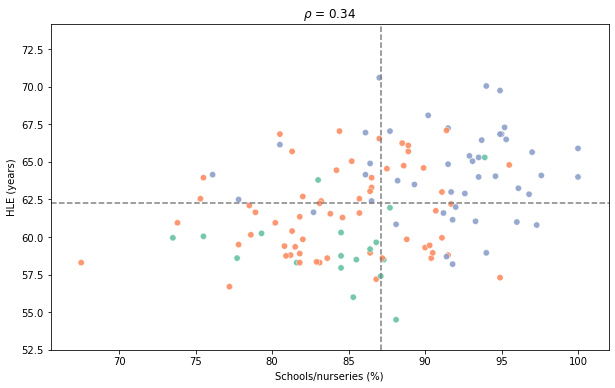

In [135]:
#Scatter plot of health vs educational outcomes with Pearson corr coeff
mean_educ = df['schools_nurseries'].mean()
educ_min = df['schools_nurseries'].min() - 2
educ_max = df['schools_nurseries'].max() + 2

mean_health = df['hle'].mean()
health_min = df['hle'].min() - 2
health_max = df['hle'].max() + 2

fig, ax = plt.subplots(figsize=(10, 6))

mask = (df['schools_nurseries'].notna() & df['hle'].notna())
dummy = df[mask]

sns.scatterplot(x='schools_nurseries', y='hle', data=dummy, hue='income_bracket', 
                s=40, hue_order=['low', 'mid', 'high'], alpha=0.9)
plt.plot([mean_educ, mean_educ], [health_min, health_max], linestyle='--', color='gray')
plt.plot([educ_min, educ_max], [mean_health, mean_health], linestyle='--', color='gray')

rho = round(np.corrcoef(dummy['hle'].dropna(), dummy['schools_nurseries'].dropna())[0,1], 2)
plt.title(f'$\\rho$ = {rho}')
plt.legend([],[], frameon=False)
plt.ylabel('HLE (years)')
plt.xlabel('Schools/nurseries (%)')

plt.ylim([health_min, health_max])
plt.xlim([educ_min, educ_max])

plt.show()

We note that there is a positive correlation here: a higher level of education appears to be positively related to an increased HLE. Furthermore, the familiar pattern from the preceding analysis is also present in that the upper-right quadrant (high education, high HLE) is largely populated with high-income districts while the lower-left quadrant (low education, low HLE) is largely populated with low- and mid-income districts.

## Final notes

The simple study here seems to suggest that in the UK a person's health and educational outcomes in life are positively related to the income of the particular district that they happen to live in. It would be interesting to map the districts geographically and make these plots interactive – there may be geographic trends that are difficult to see just by plotting the numerical quantities, and it would be good to be able to hover over a district and obtain some summary statistics. 

The study is currently very rough and would benefit from the following.
1. Bringing the health and education factors together to form indexes for each rather than using HLE and the proportion of good schools as proxies.
2. Extending the analysis to other factors available in the dataset such as GVA, travel time, new houses, access to broadband, etc. If an index could also be derived, a three-dimensional plot of this, health and education coloured by income bracket could shed more light on the relationships hinted at here.
3. Income is used here but it may not be the best measure since some areas have a higher cost of living than others. As such, it may be that something like 'expendable income per week' might be a better metric. 
4. The dataset could be augmented with other sets that may be available. For example, it would be interesting to see how funding for a given district is related to the weekly income. 